# Geographically Weighted Regression for Examining the Association between Neighborhood Mental Disorders Prevalence (NMDP) and Neighborhood Characteristics in Glasgow

## 1. Introduction

Mental health is a major public health issue in Scotland and Glasgow, with a high prevalence of mental health problems among the population. One in three Scots are affected by mental illness at some point in their lives (Scottish Government, 2017). In Glasgow, there is evidence of higher rates of mental illness than in other parts of Scotland, with particularly high levels of depression, anxiety, and psychosis (Scottish Government, 2018). Given the increasing prevalence of conditions such as depression, anxiety, and suicide, it is imperative that cities prioritize addressing the rise in mental health issues and inequality through policy initiatives. (Wang et al., 2022).

Although established risk factors for depression include a variety of individual-level characteristics, pieces of research have indicated that neighborhood-level characteristics also have a significant association with depression (Kim, 2008). The physical environment as container of daily life can either alleviate emotions or increase stress.

Previous research has established that exposure to green spaces can positively impact health outcomes and emotions (Hartig & Kahn, 2016). The quantity, distance, and accessibility of green spaces are important factors in promoting mental well-being (Houlden et al., 2019, la Rosa, 2014). Furthermore, access to essential resources, such as supermarkets, health care, and physical facilities like cafes and town halls, can have a significant impact on health behavior and ultimately physical and psychosocial health (Kim, 2008). Mixed-use developments offer residents equitable access to local amenities, facilities, and employment opportunities, which foster social cohesion and enhance mental well-being (Chau et al., 2022). Ha (2018) has proved neighborhood socioeconomic indicators, such as unemployment rate, education status, and social interaction status are related to mentally unhealthy days. Moreover, crime rates in a neighborhood can have a negative impact on the mental health of residents, leading to feelings of insecurity and loss of trust (Ross, 2000).

While some studies have examined the relationship between neighborhood built environments and mental health, these have often relied on linear regression models, which does not adequately account for spatial autocorrelation. Ha (2018) used geographically weighted regression (GWR) to analyze survey data and account for spatial correlations. However, the use of GWR with small data is limited, and there is a lack of research that explores the relationship between neighborhood built environments and mental health using big data while accounting for spatial autocorrelation. This research gap highlights the need for a more comprehensive analysis that incorporates both big data and spatial analysis techniques to better understand the relationship between neighborhood built environments and mental health outcomes.

The purpose of this study is to investigate the relationship between neighborhood built environment inequity and neighborhood mental disorders prevalence (NMDP), as indicated by the proportion of the population prescribed drugs for anxiety, depression, or psychosis, in Glasgow. Specifically, the study aims to achieve the following objectives:

1.	Compare the results obtained from the OLS model and GWR model to better understand the relationship between NMDP and neighborhood built environment.

2.	Examine whether the distribution of NMDP is unjust with regards to neighborhood amenities, including but not limited to green spaces, retail stores, healthcare facilities, public transportation facilities and other recreational resources such as cafes and town halls.

3.	Explore how the nature and significance of statistical associations between NMDP and neighborhood built environment vary across Glasgow.

The goal of this study is to deepen understanding of the spatial variation of mental health in relation to neighborhood characteristics and to identify ways to improve the fair distribution of facilities to enhance the mental well-being of neighborhood residents. The findings from this study could inform policy and practice to promote a more equitable distribution of resources in neighborhoods and improve the overall mental health of the population.


In [53]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import mapclassify as mc
from scipy.stats import norm
import contextily
from pysal.lib import weights 
from pysal.explore import esda
import shapely
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import libpysal as ps 
from scipy.stats import pointbiserialr
%matplotlib inline 

## 2. Material and methods

### 2.1. Study area

Glasgow, the largest city in Scotland, unfortunately suffers from high levels of deprivation in the UK. As per The Glasgow Indicator Project's report in 2016, using the Warwick-Edinburgh Mental Well-being Scale to evaluate positive mental health, Glasgow had the lowest score among Scottish cities between 2008 and 2011 (The Glasgow Indicator Project, 2016).

The study sample was drawn from the Scottish Index Multiple Deprivation (SIMD) dataset, which assesses the degree of disadvantage across multiple dimensions at the data zone level (Scottish Government, 2021). These neighborhoods are defined by the 2020 Census and consist of populations ranging from 500 to 1000 household residents. In the Glasgow council area, there are 746 such data zones.

In [2]:
# read files
scot_simd=gpd.read_file('SG_SIMD_2020/SG_SIMD_2020.shp')
gla_boundary=gpd.read_file('GlasgowBdry_2011')

In [3]:
# reproject it to spherical mercato
gla_boundary.to_crs(epsg=3857,inplace=True)
scot_simd.to_crs(epsg=3857, inplace=True)

# define a variable for m^2 to km^2
sqm_to_sqkm = 10**6

# create a field of areas
scot_simd['Area'] = scot_simd.area/sqm_to_sqkm

# select data zones in Glasgow
gla_simd=scot_simd.loc[scot_simd['LAName']=='Glasgow City']

Text(0.95, 0.84, 'N')

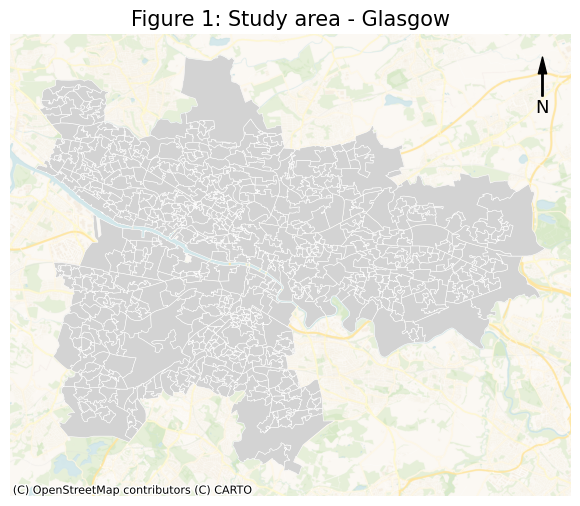

In [4]:
# plot the study area on the map
fig,ax=plt.subplots(figsize=(12,6))
gla_simd.plot(ax=ax,color='lightgrey', edgecolor='white',linewidth=0.4)
contextily.add_basemap(
    ax,
    crs=gla_simd.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels)
ax.set_title('Figure 1: Study area - Glasgow', fontsize=15)
ax.set_axis_off()
x, y, arrow_length = 0.95, 0.95, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=13,
            xycoords=ax.transAxes)

### 2.2 Neighborhood mental disorders prevalence (NMDP)

The neighborhood mental disorders prevalence is assessed based on the proportion of the population prescribed medication for anxiety, depression, or psychosis, as reported in the SIMD dataset. This proportion serves as an objective indicator of the prevalence of mental health conditions within each neighborhood. On average, 21% of the population in these neighborhoods were found to have mental health problems. Fig. 2 depicts the distribution of this proportion, which closely approximates a normal distribution.

In [5]:
# convert string into numeric
gla_simd['HlthDprsPc']=gla_simd['HlthDprsPc'].str.replace('%','').astype('int')

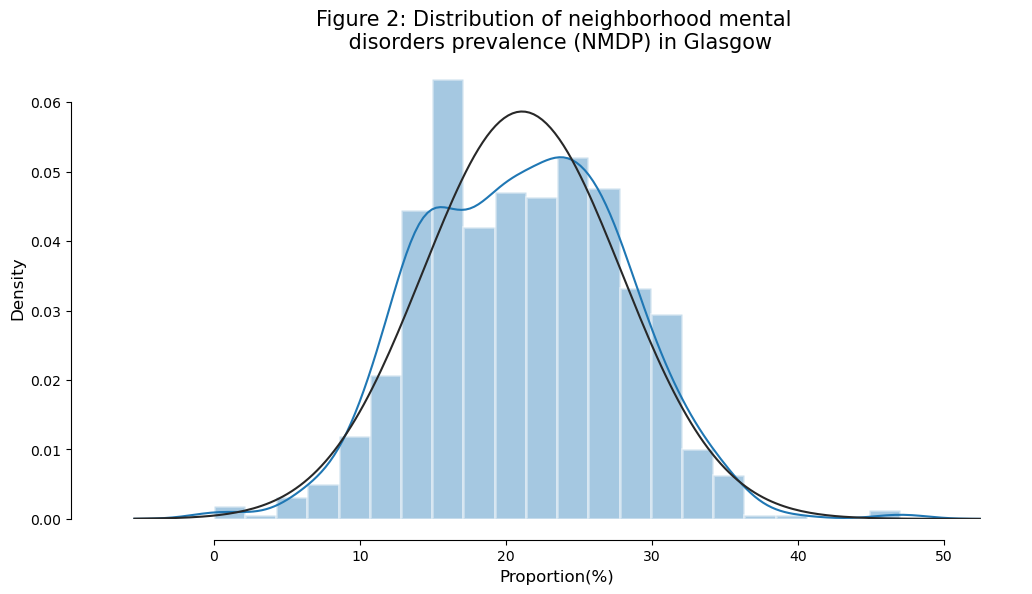

In [6]:
# plot the distribution of NMDP
from scipy.stats import norm
fig,ax=plt.subplots(figsize=(12,6))
sns.distplot(gla_simd['HlthDprsPc'],hist_kws=dict(edgecolor="white", linewidth=2),fit=norm, kde=True)
plt.title('Figure 2: Distribution of neighborhood mental \n disorders prevalence (NMDP) in Glasgow', fontsize=15)
plt.xlabel('Proportion(%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
sns.despine(offset=15, trim=True)

Fig. 3 illustrates the NMDP in the contiguous Glasgow through natural break classification. The map reveals that neighborhoods with lower NMDP are predominantly situated in the middle as opposed to other regions. Moreover, the global Moran's I (Moran's I = 0.400; z=22.088 p < 0.001) is statistically significant, indicating spatially clustered NMDP patterns throughout Glasgow. This clustering suggests a presence of both spatial dependency and spatial heterogeneity in mental health outcomes.

Text(1, 0.84, 'N')

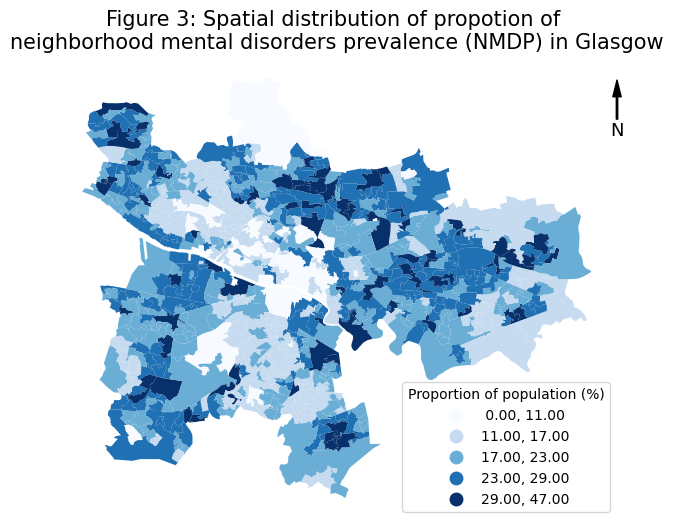

In [7]:
# take advantage of Jenks Natural Breaks Classification method (Jenks, 1967)
# which minimizes the variance within categories and maximizes the variance between categories simultaneously
fig,ax=plt.subplots(figsize=(12,6))
gla_simd.plot(ax=ax, column='HlthDprsPc', 
                 cmap = 'Blues', 
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Proportion of population (%)','loc':'lower right'})

ax.set_axis_off()
ax.set_title('Figure 3: Spatial distribution of propotion of \nneighborhood mental disorders prevalence (NMDP) in Glasgow',fontsize=15)
x, y, arrow_length = 1, 0.95, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=13,
            xycoords=ax.transAxes)


In [8]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gla_simd, k=8)
# Row-standardization
w.transform = "R"

# compute the spatial lag of NMDP
gla_simd["HlthDprsPc_lag"] = weights.spatial_lag.lag_spatial(w, gla_simd["HlthDprsPc"])

moran = esda.moran.Moran(gla_simd["HlthDprsPc"], w)

# generate Moran's I value and p-value
print("Global Moran's I: Moran’s I = %s; z= %s; P-value < %s" % (f'{moran.I:.3f}',f'{moran.z_sim:.3f}',f'{moran.p_sim:.3f}'))

Global Moran's I: Moran’s I = 0.400; z= 22.435; P-value < 0.001


### 2.3 Measures of neighborhood built environment

After reviewing the literature about the correlation between mental health and neighborhood characteristics I collected multi-source neighborhood built environment data including green spaces, facilities and POIs, and controlled three neighborhood level socio-economic characteristics along with a neighborhood problem indicator (Chau et al., 2022; Ha, 2018, Houlden et al., 2019, la Rosa, 2014, Hartig & Kahn, 2016, Kim, 2008, Ross, 2000, Ross, 2000, Stafford & Marmot, 2003). Main explanatory variables collected from Scottish Government and OpenStreetMap are divided into three categories i.e., greenspaces, services and amenities and accessibility.

#### 2.3.1 Neighborhood green space

Evidence suggests that mental health is related to visits to greenspaces and accessibility (Houlden et al., 2018). Moreover, the amount of local space devoted to green space was associated with life satisfaction(Levasseur et al., 2015). Therefore, public parks and the access points of each park (Fig. 4) were used to calculate the Euclidean distance from the centroid of each data zone to the closest park and to determine the corresponding park’s area. Then the proportion of green space in each neighborhood was calculated.

In [9]:
# read green space file
green_space=gpd.read_file('open-greenspace_4982655')

In [10]:
# select observations with function of 'Public Park Or Garden' 
green_space=green_space[green_space['function']== 'Public Park Or Garden' ]

# convert EPSG
green_space.to_crs(epsg=3857,inplace =True)

# convert geometry from 3D to 2D
green_space.geometry = shapely.wkb.loads(
        shapely.wkb.dumps(green_space.geometry, output_dimension=2))

# select and join the parks which intersect with data zones in Glasgow
gla_green_t = gpd.sjoin(green_space[['id','function','geometry']],
                        gla_simd[['DZName','DataZone','Area','geometry']],
                        op='intersects')

# drop field of 'index_right'
gla_green_t = gla_green_t.drop(columns=['index_right'])

# 107 parks in Glasgow. Some of them cross several data zones.
print('There are',len(gla_green_t['id'].unique()),'parks seperated in to',len(gla_green_t),'segments by data zones in Glasgow.')

There are 107 parks seperated in to 197 segments by data zones in Glasgow.


In [11]:
# read access point file of parks
green_acc_p=gpd.read_file('opgrsp_gb/opgrsp_gb/opgrsp_gb.gpkg')

In [12]:
# convert EPSG
green_acc_p.to_crs(epsg=3857,inplace =True)

# select access points of parks in Glasgow
gla_green_acp = gpd.sjoin(green_acc_p,gla_green_t,op='touches')

# drop duplicated access points observations
gla_green_acp=gla_green_acp.drop_duplicates(subset=['id_left','id_right'],keep='first')

Text(1, 0.84, 'N')

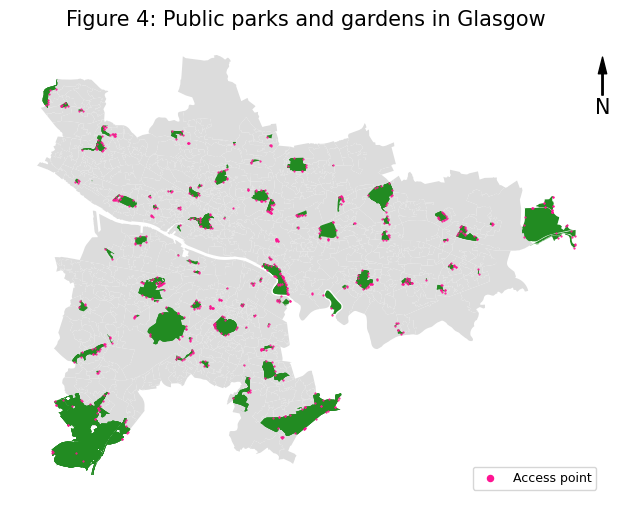

In [13]:
# plot the green spaces and access points
fig,ax=plt.subplots(figsize=(12,6))
gla_simd.plot(ax=ax,color='gainsboro',alpha=1)
gla_green_t.plot(ax=ax,color='forestgreen')
gla_green_acp.plot(ax=ax,color='deeppink',markersize=0.3,label='Access point')
ax.legend(loc="lower right", markerscale=8,fontsize=9)
ax.set_axis_off()
ax.set_title('Figure 4: Public parks and gardens in Glasgow', fontsize=15)
x, y, arrow_length = 1, 0.95, 0.11
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

In [14]:
# 1.1 get the closest park and the area of the park

# generate centroid of each data zone
gla_simd['center']=gla_simd.geometry.centroid

# get the name of the closest park
# define the function
def closest_park(geom, gla_green_acp):
    dist = gla_green_acp.geometry.distance(geom)
    idx = dist.idxmin()
    closest_park = gla_green_acp.loc[idx,'id_right']
    return closest_park

# run the function
gla_simd['closest_park']=gla_simd['center'].apply(closest_park,gla_green_acp=gla_green_acp)

In [15]:
# obtain the area of closest park
park_area = green_space[['id','geometry']]
park_area['park_area']=park_area.area

# transfer GeoDataFrame to DataFrame
park_area=pd.DataFrame(park_area)

park_area=park_area[['id','park_area']]

# convert the values into string
park_area['id']=park_area['id'].astype(str)
gla_simd['closest_park'] = gla_simd['closest_park'].astype(str)

# merge GeoDataFrame and DataFrame based on parks' ID
gla_simd = gla_simd.merge(park_area,how='left',left_on='closest_park',right_on='id')

In [16]:
# detect null value and fix it
gla_simd[pd.isnull(gla_simd).any(axis=1)].index

Int64Index([320], dtype='int64')

In [17]:
# fill null with correct value

# specify the id of the missing park
gla_simd.loc[320,'closest_park']

# extract the correct id of the park and replace null value
gla_simd['id'].fillna('E56DE6BD-A9D2-13A9-E053-AAEFA00A0D0E',inplace=True)

# get the index of the missing park
null_index=park_area[park_area['id'].isin(['E56DE6BD-A9D2-13A9-E053-AAEFA00A0D0E'])].index

correct_area=park_area.loc[null_index,'park_area']

gla_simd['park_area'].fillna(int(correct_area), inplace=True)

# convert m^2 to km^2
gla_simd['park_area']=gla_simd['park_area']/sqm_to_sqkm
gla_simd['park_area']=gla_simd['park_area'].round(2)

In [18]:
# 1.2. calculate green space accessibility

# caculate the min distance between each neighboorhood centorid to closest park access points

#define function to calculate min distance
def min_distance(geom, gla_green_acp):
    dist = gla_green_acp.geometry.distance(geom)
    min_distance = dist.min()
    return min_distance

# create a field and apply the function to all data zone centroid
gla_simd['min_distance']=gla_simd['center'].apply(min_distance,gla_green_acp=gla_green_acp)
                                                  

In [19]:
#1.3. calculate the proportion of green spaces in each data zone

# process GeoDataFrame
gla_green_t=gla_green_t.drop_duplicates(subset=('geometry'))
gla_green_t=gla_green_t[['id','geometry']]

# intersect green spaces and data zones
green_dz_intersection = gpd.overlay(gla_green_t,gla_simd,how='intersection')

# get the area of green space in each data zone
green_dz_intersection['green_intersect_area']=green_dz_intersection.geometry.area

# get the proportion of green spaces in each data zone
green_dz_intersection['prop_green']=green_dz_intersection['green_intersect_area']/green_dz_intersection['Area']/sqm_to_sqkm*100


# merge the GeoDataFrames
green_dz_intersection=pd.DataFrame(green_dz_intersection)
green_dz_intersection=green_dz_intersection[['DataZone','prop_green']]
test=gla_simd.merge(green_dz_intersection,how='left',on='DataZone')

# aggregate area of several parks into one value
green_prop=test.groupby('DataZone')['prop_green'].sum()
green_prop=pd.DataFrame(green_prop)

# merge again
gla_simd=gla_simd.merge(green_prop,how='left',on='DataZone')


#### 2.3.2 Neighborhood services and amenities

Some studies have revealed a strong correlation between life satisfaction and accessibility to diverse destinations including shops, services and resources(Vaughan et al., 2016). POIs of food, drinks and retails are significant places that meet residents’ needs of relax and leisure. I calculated the density of these POIs in every neighborhood. In addition, I generated Euclidean (straight-line) distance buffers as service areas at a radius of 500m and recognized which neighborhoods intercept with these service areas of libraries.  Then I specified data zone having community centers which could promote social inclusion.

In [20]:
# read the POIs file
gla_poi=gpd.read_file('poi/poi/poi.gpkg')

In [21]:
# convert EPSG
gla_poi.to_crs(epsg=3857,inplace=True)

# select POIs located in Glasgow
gla_poi=gpd.sjoin(gla_poi,gla_simd,op='within')

In [22]:
# 2.1 get the food/drink/retail density
# get the food/drink/retail POIs
gla_poi[gla_poi['groupname']=='Accommodation, Eating and Drinking']['categoryname'].unique()

gla_poi[gla_poi['groupname']=='Retail']['categoryname'].unique()

# observations with values of 'Eating and Drinking', 'Accommodation','Clothing and Accessories', 'Food, Drink and Multi Item Retail' will be kept
gla_poi_fdr = gla_poi[gla_poi['categoryname'].isin(['Eating and Drinking', 'Accommodation', 'Clothing and Accessories', 'Food, Drink and Multi Item Retail'])]

# count the numbers of POIs in each data zone
gla_poi_fdr=gla_poi_fdr['DataZone'].value_counts()

# convert the series into DataFrame and rename the columns
gla_poi_fdr=pd.DataFrame(gla_poi_fdr)

gla_poi_fdr=gla_poi_fdr.reset_index()

gla_poi_fdr.columns = ['DataZone','fdr_Count']

# merge the DataFrames 
gla_simd=gla_simd.merge(gla_poi_fdr,how='left',on='DataZone')

# transfer NaN value into 0
gla_simd=gla_simd.fillna(0)

# calculate the density
gla_simd['fdr_density']=gla_simd['fdr_Count']/gla_simd['Area']

In [23]:
#2.2 specify which data zones intercept with the 500m buffer of library

# get library data
gla_poi_li=gla_poi[gla_poi['classname']=='Libraries']

# create 500m buffer for libraries
gla_poi_li_500=gla_poi_li.buffer(500)
gla_poi_li_500=gpd.GeoDataFrame(gla_poi_li_500)
gla_poi_li_500.columns=['geometry']

# specify which data zones are in the 500 buffers of libraries
gla_poi_li_500=gpd.sjoin(gla_poi_li_500,gla_simd,op='overlaps')

gla_poi_li_500=gla_poi_li_500['DataZone'].value_counts()
gla_poi_li_500=pd.DataFrame(gla_poi_li_500)
gla_poi_li_500=gla_poi_li_500.reset_index()

gla_poi_li_500.columns=['DataZone','library']

gla_poi_li_500['library']='yes'
gla_simd=gla_simd.merge(gla_poi_li_500,how='left',on='DataZone')

# fill NaN with 'no'
gla_simd=gla_simd.fillna('no')

In [24]:
# 2.3 get the community centers data

# subset POIs of community center
gla_poi_cc=gla_poi[gla_poi['classname']=='Halls and Community Centres']

gla_poi_cc=gla_poi_cc['DataZone'].value_counts()

gla_poi_cc=pd.DataFrame(gla_poi_cc)
gla_poi_cc=gla_poi_cc.reset_index()
gla_poi_cc.columns=['DataZone','community_center']

# specify data zones with community center
gla_poi_cc['community_center']='yes'

gla_simd=gla_simd.merge(gla_poi_cc,how='left',on='DataZone')
gla_simd=gla_simd.fillna('no')

#### 2.3.3 Neighborhood accessibility

Proximity to resources and recreational facilities is important to well-being(Levasseur et al., 2015). The public transportation accessibility for residents to GP and leisure center can be obtained from SIMD (Scottish Government, 2020). I then computed the density of bus stations per square kilometer in every data zone.

In [25]:
# 3.1 calculate the bus stop density
gla_poi['groupname'].unique()
gla_poi[gla_poi['groupname']=='Transport']['categoryname'].unique()
gla_poi[gla_poi['categoryname']=='Bus Transport']['classname'].unique()

# bus stops density
gla_poi_bustops=gla_poi[gla_poi['classname']=='Bus Stops']

gla_poi_bustops=gla_poi_bustops['DataZone'].value_counts()
gla_poi_bustops=pd.DataFrame(gla_poi_bustops)
gla_poi_bustops=gla_poi_bustops.reset_index()
gla_poi_bustops.columns=['DataZone','Bus_stop_count']

gla_simd=gla_simd.merge(gla_poi_bustops,how='left',on='DataZone')
gla_simd=gla_simd.fillna(0)
gla_simd['bus_stop_density']=gla_simd['Bus_stop_count']/gla_simd['Area']

#### 2.3.4 Neighborhood SES and problems

I controlled three neighborhood-level socio-economic variables which are employment rate, income deprived rate and education ratio from dataset of SIMD (Scottish Government, 2020) to alleviate the potential deviation on the regression process. Crime rate in neighborhoods is also included because security from crime has been proven relevant to mental health, especially crime-related safety(Yen et al., 2009).

The detailed description and spatial distribution of variables are displayed in Table 1 and Fig. 5, respectively.

In [26]:
# form the final DataFrame for explainatory variables
df=gla_simd[['DataZone','geometry',
            'HlthDprsPc',# neighborhood mental health level (NMDP)
            'park_area','min_distance','prop_green', # neighborhood green spaces
            'fdr_density','library','community_center', # neighborhood services and amenities
            'GAccPTGP','GAccPTRet','bus_stop_density', # neighborhood accessibility
            'EmpRate','EduNoQuals','IncRate', # neighborhood SES
            'CrimeRate']] # neighborhood problems
# convert string into numeric
df['EmpRate']=df['EmpRate'].str.replace('%','').astype('int')
df['IncRate']=df['IncRate'].str.replace('%','').astype('int')

In [27]:
# add dummy variables for categorical variables
df_dummies = pd.get_dummies(data=df, columns=['library','community_center'])

In [28]:
# generate descriptive statistics
descriptive_statstics=df_dummies.describe().applymap(lambda x: f"{x:0.2f}")
descriptive_statstics=descriptive_statstics[['HlthDprsPc','park_area','min_distance','prop_green','fdr_density','library_yes','community_center_yes','GAccPTGP','GAccPTRet','bus_stop_density','EmpRate','EduNoQuals','IncRate','CrimeRate']]
descriptive_statstics=descriptive_statstics.round(2)
# note that 'library_yes' and 'community_center_yes' are dummy variables whose mean indicate the proportion

In [54]:
# read file of description of variables
description=pd.read_excel('description of variables.xlsx')

# show full content of DataFram
pd.set_option('display.max_colwidth', 1000)

# add descriptive statistics to table
description=description.set_index('Variables')
description['Mean/%']=descriptive_statstics.loc['mean']
description['Std']=descriptive_statstics.loc['std']

# convert ratio of dummy variable to proportion
description.loc['library_yes','Mean/%']= '{:.0%}'.format(float(description.loc['library_yes','Mean/%']))
description.loc['community_center_yes','Mean/%']= '{:.0%}'.format(float(description.loc['community_center_yes','Mean/%']))
description.loc['library_yes':'community_center_yes','Std']='/'

description=description.style.set_table_attributes("style='display:inline'").set_caption('Table 1: Description and descriptive statistics of variables')

description

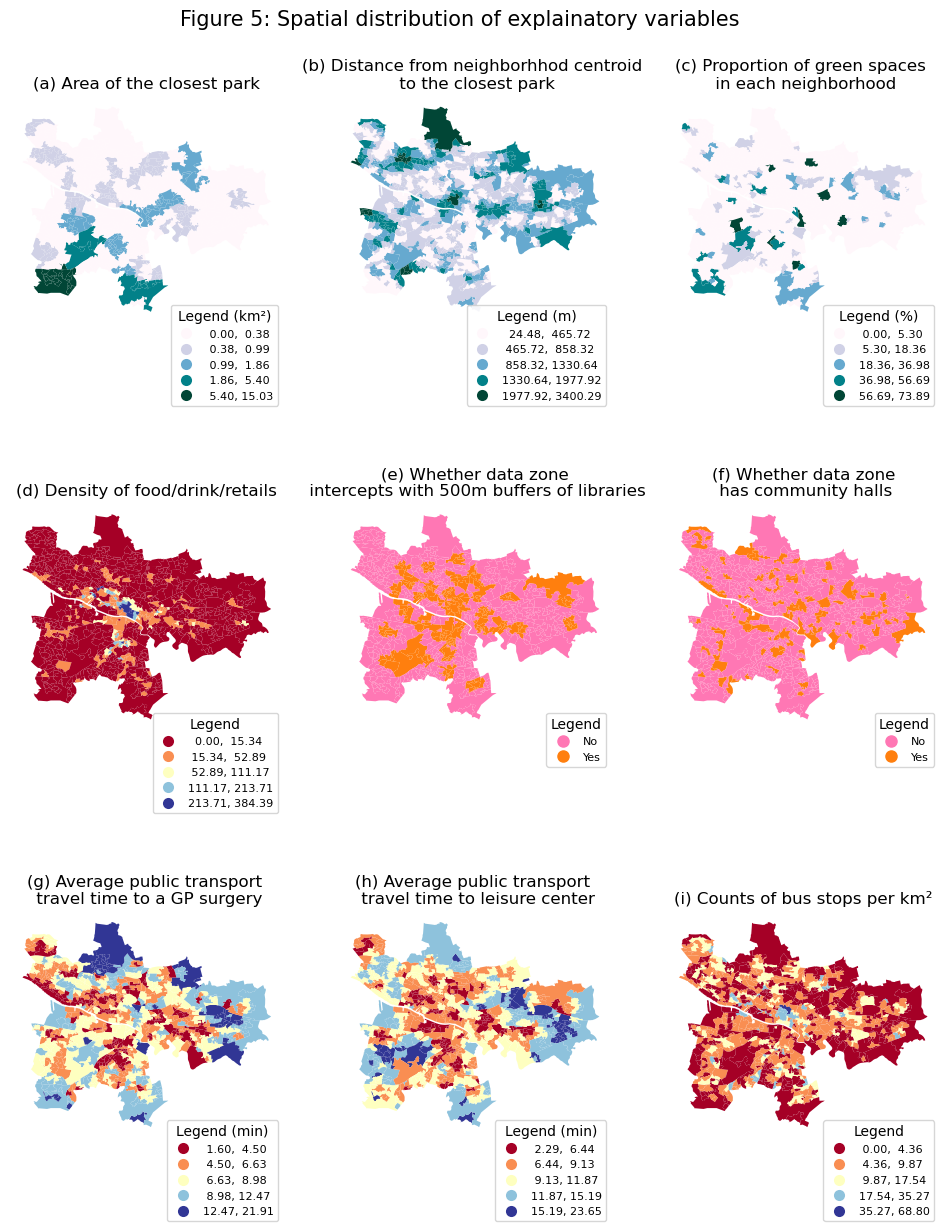

In [30]:
# plot spatial distribution of variabls

from matplotlib.colors import ListedColormap
# Spatial distribution of explainatory variables
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,15))
fig.suptitle('Figure 5: Spatial distribution of explainatory variables', fontsize=15,y=0.9)
axs = axs.flatten()

ax = axs[0]
df.plot(ax=ax, column='park_area', 
                 cmap = 'PuBuGn',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend (km²)',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(a) Area of the closest park")
ax.set_axis_off()

ax = axs[1]
df.plot(ax=ax, column='min_distance', 
                 cmap = 'PuBuGn',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend (m)',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(b) Distance from neighborhhod centroid \n to the closest park")
ax.set_axis_off()

ax = axs[2]
df.plot(ax=ax, column='prop_green', 
                 cmap = 'PuBuGn',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend (%)',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(c) Proportion of green spaces \n in each neighborhood")
ax.set_axis_off()

ax = axs[3]
df.plot(ax=ax, column='fdr_density', 
                 cmap = 'RdYlBu',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(d) Density of food/drink/retails")
ax.set_axis_off()


ax = axs[4]
color_map = ListedColormap([(1, 0.46666667, 0.70588235, 1.),
                            (1.        , 0.49803922, 0.05490196, 1.)], name='my_colormap')

# Create a map of the dummy variable
df_dummies.plot(column='library_yes', categorical=True, cmap=color_map, legend=True,
                 legend_kwds={'title': 'Legend', 'fontsize': 8, 'markerscale': 0.8, 'loc': 'upper right',
                              'bbox_to_anchor': (1, 0.1)}, ax=ax)

# Manually create legend handles and labels
handles, labels = [], []
for i, category in enumerate(df_dummies['library_yes'].unique()):
    if category == 0:
        label = 'No'
    else:
        label = 'Yes'
    handles.append(plt.Line2D([0], [0], color=color_map(i), marker='o', linestyle='', markersize=10))
    labels.append(label)

# Add handles and labels to legend
ax.legend(handles, labels, title='Legend', fontsize=8, markerscale=0.8, loc='upper right', bbox_to_anchor=(1, 0.1))
ax.set_title("(e) Whether data zone\n intercepts with 500m buffers of libraries")
ax.set_axis_off()

ax = axs[5]
color_map = ListedColormap([(1, 0.46666667, 0.70588235, 1.),
                            (1.        , 0.49803922, 0.05490196, 1.)], name='my_colormap')

# Create a map of the dummy variable
df_dummies.plot(column='community_center_yes', categorical=True, cmap=color_map, legend=True,
                 legend_kwds={'title': 'Legend', 'fontsize': 8, 'markerscale': 0.8, 'loc': 'upper right',
                              'bbox_to_anchor': (1, 0.1)}, ax=ax)

# Manually create legend handles and labels
handles, labels = [], []
for i, category in enumerate(df_dummies['community_center_yes'].unique()):
    if category == 0:
        label = 'No'
    else:
        label = 'Yes'
    handles.append(plt.Line2D([0], [0], color=color_map(i), marker='o', linestyle='', markersize=10))
    labels.append(label)

# Add handles and labels to legend
ax.legend(handles, labels, title='Legend', fontsize=8, markerscale=0.8, loc='upper right', bbox_to_anchor=(1, 0.1))
ax.set_title("(f) Whether data zone\n has community halls")
ax.set_axis_off()

ax = axs[6]
df.plot(ax=ax, column='GAccPTGP', 
                 cmap = 'RdYlBu',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend (min)',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(g) Average public transport \n travel time to a GP surgery")
ax.set_axis_off()

ax = axs[7]
df.plot(ax=ax, column='GAccPTRet', 
                 cmap = 'RdYlBu',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend (min)',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(h) Average public transport \n travel time to leisure center")
ax.set_axis_off()

ax = axs[8]
df.plot(ax=ax, column='bus_stop_density', 
                 cmap = 'RdYlBu',
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Legend',
                                'fontsize':8,
                                'markerscale':0.8,
                                'loc':'upper right',
                                'bbox_to_anchor':(1, 0.1)})
ax.set_title("(i) Counts of bus stops per km²")
ax.set_axis_off()

A preliminary non-spatial exploration of numeric variables via histograms, bivariate scatter and linear regression model fit plots and Pearson’s correlations are shown in Fig. 6. If the absolute value of the coefficient between variables was greater than 0.7, only one would be kept in the subsequent model. Informed by this exploratory analysis, EduNoQuals and EmpRate had to be removed due to the strong positive correaltion to IncRate to facilitate robust regression estimations. As a result, income rate was used to indicate neighborhood SES in general.

Text(0.5, 0.98, 'Figure 6: Correlation and histgrams')

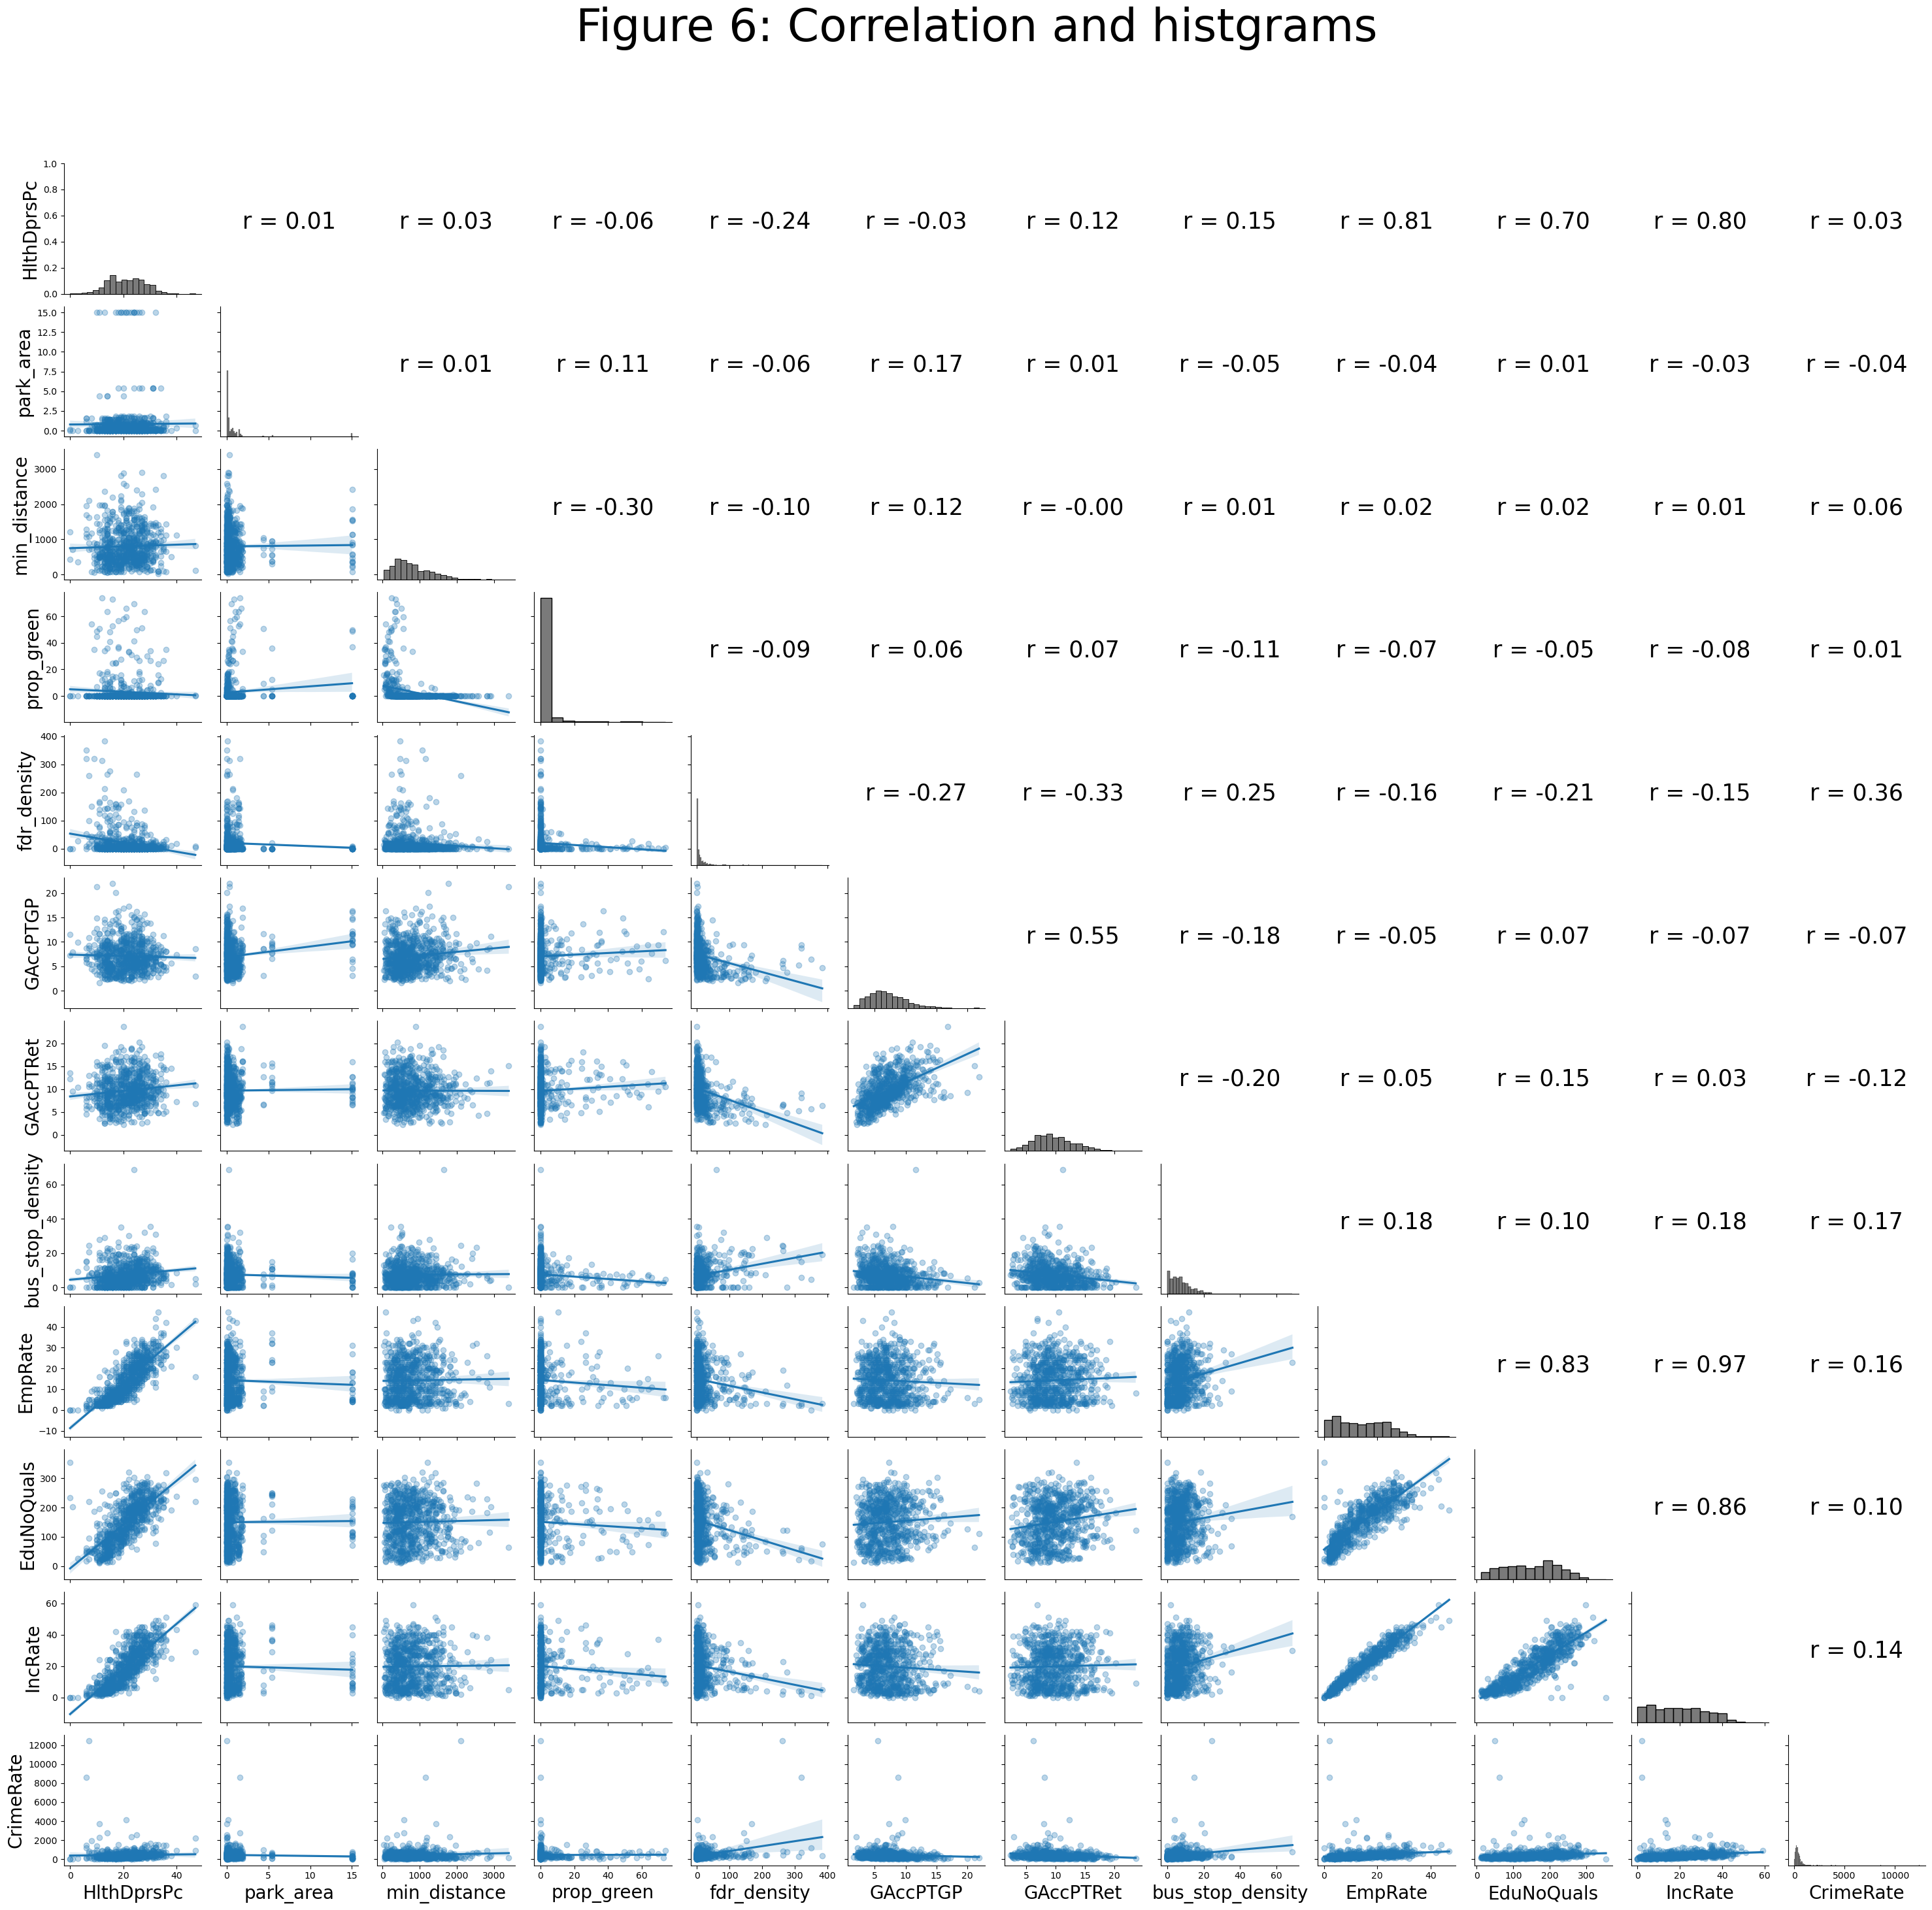

In [31]:
# plot correlations and histograms 
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size=25)
    ax.set_axis_off()

mpl.rcParams["axes.labelsize"] = 20
g = sns.PairGrid(df)
    
plt.subplots_adjust(top=0.9)
g.map_diag(sns.histplot,color=".3")
g.map_lower(sns.regplot, scatter_kws={'alpha':0.3})
g.map_upper(reg_coef)
g.fig.suptitle('Figure 6: Correlation and histgrams',fontsize=50)

### 2.4 Regression methodology

Firstly, I employed the ordinary least square (OLS) regression model to estimate the NMDP between neighborhood built environment and neighborhood SES throughout the study area. Collinearity was detected by the variance inflation factor (VIF). 
 
Then I examined the distribution of residual errors of the OLS models revealing spatial autocorrelation which led to potential deviation (Anselin, 1988). Based on this analysis, I decided to conduct a geographically weighted regression (GWR). GWR is an extension of OLS that enables the coefficient to vary with geographical position and explores the spatial non-stationarity by estimating local parameters instead of global ones. (Brunsdon et al., 1996).  Taking advantage of GWR, separated regression were created for every location in a dataset based on the surrounding neighbors’ association to capture the regional variation (Brunsdon et al., 1996). 

## 3. Result

Table 2 and Table 3 show the heteroskedasticity robust results of the OLS model and the VIF value. The VIF values, all below 2, indicate the absence of any apparent collinearity among independent variables. The density of drinks, food and retails POIs and binary variable of library were significantly negatively correlated with neighborhood mental health prevalence (NMDP). Neighborhoods with more those POIs and intersect with the 500m buffer of libraries have lower proportion of population suffer from mental health problems. GAccPTGP is negatively associated with NMDP, while GAccPTRet is positively associated. This indicates that people living in the neighborhood where average travel time on public transportation to leisure centers longer are more likely to have mental health problems, while longer travel times to general practitioners (GPs) reduce the likelihood of mental health problems. In addition, neighborhoods have higher bus stop density and income deprived rate tends to be exposed to more possibility of mental health issue.

In [32]:
# construct the regression equation
reg_exp = 'HlthDprsPc ~ park_area + min_distance + prop_green + fdr_density + library_yes + community_center_yes + GAccPTGP + GAccPTRet + bus_stop_density + IncRate + CrimeRate'

# build the OLS regression model:
olsr_model = smf.ols(formula=reg_exp, data=df_dummies)

# train the model:
olsr_model_results = olsr_model.fit()

In [33]:
# make use of statsmodels to apply the HC0 estimators
# to perform statistical inference that is robust to heteroskedasticity.
olsr_model_results = olsr_model.fit(cov_type='HC0')
title_str = "Table 2: Robust OLS regression results"
print(title_str)
print(olsr_model_results.summary())

Table 2: Robust OLS regression results
                            OLS Regression Results                            
Dep. Variable:             HlthDprsPc   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     129.0
Date:                Mon, 27 Mar 2023   Prob (F-statistic):          2.97e-163
Time:                        08:55:19   Log-Likelihood:                -2074.4
No. Observations:                 746   AIC:                             4173.
Df Residuals:                     734   BIC:                             4228.
Df Model:                          11                                         
Covariance Type:                  HC0                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [34]:
# detect the multicolliniearity
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('HlthDprsPc ~ park_area + min_distance + prop_green + fdr_density + library_yes +community_center_yes + GAccPTGP + GAccPTRet + bus_stop_density + IncRate +  CrimeRate', data=df_dummies, return_type='dataframe')

# calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif=vif.set_index('variable')

In [56]:
# OLS result table

table = pd.DataFrame({'Coefficients': olsr_model_results.params,
                      'Robust SE': olsr_model_results.HC0_se,
                      'Robust t': olsr_model_results.tvalues,
                      'Robust P': olsr_model_results.pvalues,
                      '':'',
                      'VIF': vif.VIF
                      })
# Add significance stars
alpha = 0.05
table[''] = ['*' if p < alpha else '' for p in table['Robust P']]

table.index = table.index.map(str)
table.index.name = 'Variable'
table['Coefficients'] = table['Coefficients'].map('{:.3f}'.format)
table['Robust SE'] = table['Robust SE'].map('{:.3f}'.format)
table['Robust t'] = table['Robust t'].map('{:.3f}'.format)
table['Robust P'] = table['Robust P'].map('{:.3f}'.format)
table['VIF'] = table['VIF'].map('{:.3f}'.format)

table=table.style.set_table_attributes("style='display:inline'").set_caption('Table 3: Results of robust ordinary least square (OLS) model')

table

Fig. 7ab show the frequency distribution histograms of fitting residuals and spatial distribution of residuals respectively. Global autocorrelation of the residuals for OLS model was detected by Global Moran's I (Moran’s I = 0.715; z= 39.445; P-value < 0.001). The Local Moran's I revealed significant spatial clustering in the OLS results, as depicted in Fig. 7c. This clustering of residuals is indicative of locations and directions where the OLS models tend to either overestimate or underestimate the associations between neighborhood characteristics and NMDP across Glasgow. For example, negative residuals in the center of Glasgow suggest that the model overpredicts the prevalence of mental disorders in those neighborhoods, while it underestimated in the surrounding areas of the city.

In [36]:
# get the rediduals of OLS regression
gla_simd['resid']=olsr_model_results.resid

In [37]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gla_simd, k=8)
# Row-standardization
w.transform = "R"

# compute the spatial lag of rediduals
gla_simd["resid"] = weights.spatial_lag.lag_spatial(w, gla_simd["resid"])

moran_resid = esda.moran.Moran(gla_simd["resid"], w)

# generate Moran's I value and p-value
print("Global Moran's I: Moran’s I = %s; z= %s; P-value < %s" % (f'{moran_resid.I:.3f}',f'{moran_resid.z_sim:.3f}',f'{moran_resid.p_sim:.3f}'))


Global Moran's I: Moran’s I = 0.715; z= 40.772; P-value < 0.001


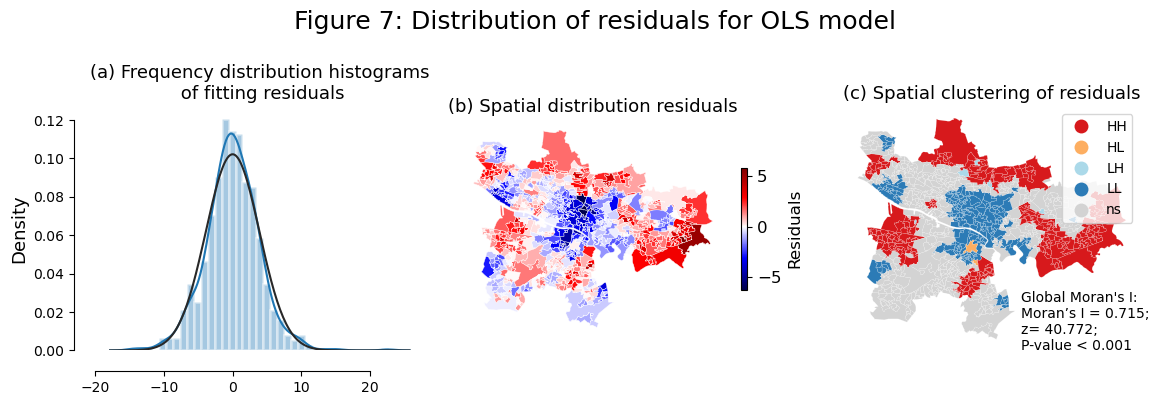

In [38]:
from scipy import stats
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle('Figure 7: Distribution of residuals for OLS model', fontsize=18,y=1)
axs = axs.flatten()


ax = axs[0]
sns.distplot(olsr_model_results.resid, fit=stats.norm,hist_kws=dict(edgecolor="white", linewidth=2),ax=ax)
sns.despine(offset=15, trim=True,ax=ax)
ax.set_title("(a) Frequency distribution histograms\n of fitting residuals",fontsize=13)
ax.set_ylabel("Density", fontsize=13)

ax = axs[1]
# Set color map
cmap = plt.cm.seismic

# Find min and max values of residuals
gla_resid_min = gla_simd['resid'].min()
gla_resid_max = gla_simd['resid'].max()
vmin = np.min([gla_resid_min])
vmax = np.max([gla_resid_max])

# If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
# If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
# Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

# Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)  # adjust size with shrink parameter
# Set colorbar label
cbar.set_label('Residuals', fontsize=12)

# Set colorbar tick label font size
cbar.ax.tick_params(labelsize=12)

# Plot residuals
gla_simd.plot('resid', cmap=sm.cmap, ax=ax,vmin=vmin, vmax=vmax, **{'edgecolor':'white','linewidth':0.3, 'alpha':1})
ax.set_axis_off()
ax.set_title("(b) Spatial distribution residuals",fontsize=13)


ax = axs[2]
from splot import esda as esdaplot
lisa = esda.moran.Moran_Local(gla_simd["resid"], w,permutations=9999)
# Plot Quandrant colors In this case, we use a 5% significance
esdaplot.lisa_cluster(lisa, gla_simd, p=0.05, ax=ax)
ax.set_axis_off()
ax.set_title("(c) Spatial clustering of residuals",fontsize=13)
ax.text(0.6,0, "Global Moran's I: \nMoran’s I = %s; \nz= %s; \nP-value < %s" % (f'{moran_resid.I:.3f}',f'{moran_resid.z_sim:.3f}',f'{moran_resid.p_sim:.3f}'), transform=ax.transAxes, fontsize=10)

fig.tight_layout()    

Table 4 provides a summary of the results from our GWR analysis on the relationship between NMDP and neighborhood characteristics. I selected six significant explanatory variables and included them in GWR model. The GWR model generated a fixed bandwidth (BW = 141) to all independent variables. This approach reduced the spatial autocorrelation of residuals, as indicated by the Moran's I statistic (Moran’s I = 0.41, z = 24.143; p < 0.001) depicted in Fig. 8ab, although it did not completely eliminate it. In terms of model fit, adjusted R square value generated by the local model is improved to 0.75 (range: 0.54–0.90) as shown in Fig. 8c, indicating a large improvement over OLS model. The lower AICc value indicates that GWR is more powerful in identifying the local-scale association between NMDP and neighborhood characteristics. It is clear that models that consider spatial dependence and heterogeneity offer advantages over non-spatial OLS models. In this regard, the coefficients estimated by GWR were deemed more representative of the prevalence of mental disorders at the neighborhood level than those obtained through OLS.

In [39]:
# build GWR model 

# select variables
y = df_dummies['HlthDprsPc'].values.reshape((-1,1)) # reshape is needed to have column array

X = df_dummies[[
            'fdr_density','library_yes',
            'GAccPTGP','GAccPTRet','bus_stop_density',
            'IncRate']].values

# define coordinates
df_dummies['X'] = df_dummies.geometry.centroid.x
df_dummies['Y'] = df_dummies.geometry.centroid.y

u = df_dummies['X']
v = df_dummies['Y']
coords = list(zip(u,v))

X = (X - X.mean(axis=0)) / X.std(axis=0)

y = y.reshape((-1,1))

y = (y - y.mean(axis=0)) / y.std(axis=0)

In [44]:
# select GWR bandwidth

gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

In [46]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 141.0


In [47]:
# generate the result of GRW regression
gwr_results = GWR(coords, y, X, gwr_bw).fit()
print('Table 4: Results of GWR model')
print(gwr_results.summary())

Table 4: Results of GWR model
Model type                                                         Gaussian
Number of observations:                                                 746
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            247.828
Log-likelihood:                                                    -647.486
AIC:                                                               1308.972
AICc:                                                              1311.167
BIC:                                                              -4640.454
R2:                                                                   0.668
Adj. R2:                                                              0.665

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------

In [48]:
# obtain the residuals of GWR regression
gla_simd['gwr_resid']=gwr_results.resid_response

In [49]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gla_simd, k=8)
# Row-standardization
w.transform = "R"

# compute the spatial lag of rediduals
gla_simd["gwr_resid"] = weights.spatial_lag.lag_spatial(w, gla_simd["gwr_resid"])

gwr_moran_resid = esda.moran.Moran(gla_simd["gwr_resid"], w)

print("Global Moran's I: Moran’s I = %s; z= %s; P-value < %s" % (f'{gwr_moran_resid.I:.3f}',f'{gwr_moran_resid.z_sim:.3f}',f'{gwr_moran_resid.p_sim:.3f}'))

Global Moran's I: Moran’s I = 0.419; z= 24.841; P-value < 0.001


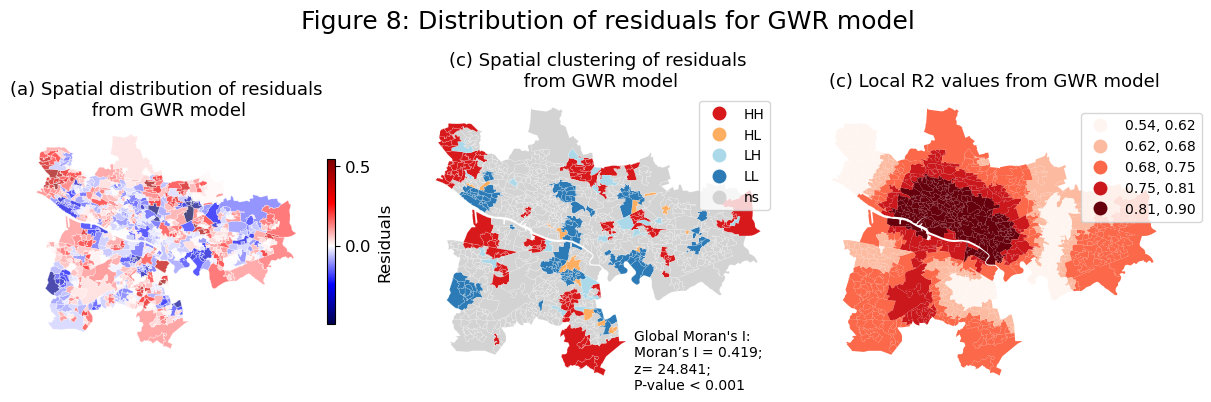

In [50]:
# plot distribution of residuals for GWR regression
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle('Figure 8: Distribution of residuals for GWR model', fontsize=18,y=1.03)
axs = axs.flatten()


ax = axs[0]
# Set color map
cmap = plt.cm.seismic

#Find min and max values of residuals

gwr_resid_min = gla_simd['gwr_resid'].min()
gwr_resid_max = gla_simd['gwr_resid'].max()
vmin = np.min([gwr_resid_min])
vmax = np.max([gwr_resid_max])

# If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
# If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
# Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

# Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)  # adjust size with shrink parameter
# Set colorbar label
cbar.set_label('Residuals', fontsize=12)

# Set colorbar tick label font size
cbar.ax.tick_params(labelsize=12)

# Plot residuals
gla_simd.plot('gwr_resid', cmap=sm.cmap, ax=ax,vmin=vmin, vmax=vmax, **{'edgecolor':'white','linewidth':0.3, 'alpha':0.7})
ax.set_axis_off()
ax.set_title("(a) Spatial distribution of residuals\n from GWR model",fontsize=13)


ax = axs[1]
lisa = esda.moran.Moran_Local(gla_simd["gwr_resid"], w,permutations=9999)
# Plot Quandrant colors In this case, we use a 5% significance
esdaplot.lisa_cluster(lisa, gla_simd, p=0.05, ax=ax)
ax.set_axis_off()
ax.set_title("(c) Spatial clustering of residuals\n from GWR model",fontsize=13)
ax.text(0.6,0, "Global Moran's I: \nMoran’s I = %s; \nz= %s; \nP-value < %s" % (f'{gwr_moran_resid.I:.3f}',f'{gwr_moran_resid.z_sim:.3f}',f'{gwr_moran_resid.p_sim:.3f}'), transform=ax.transAxes, fontsize=10)


ax = axs[2]
# Add R2 to GeoDataframe 
df_dummies['gwr_R2'] = gwr_results.localR2
df_dummies.plot(column='gwr_R2', cmap = 'Reds', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('(c) Local R2 values from GWR model',fontsize=13)
ax.set_axis_off()

fig.tight_layout()    

Figure 9 demonstrates the spatial patterns of the parameter estimates of the six explanatory variables including the density of drinks, food and retails of POI (Fig. 9a), neighborhoods intercepted with 500m buffers of libraries (Fig. 9b), average public transportation time to GP and leisure center (Fig. 9c and 9d), density of bus stop (Fig. 9e) and income deprived rate (Fig. 9f), which show spatial non-stationarity. Positive estimates are depicted in red, while negative estimates are depicted in blue. Locations where the estimates were found to be non-significant are identified using a t-value filter and are masked in light grey. 

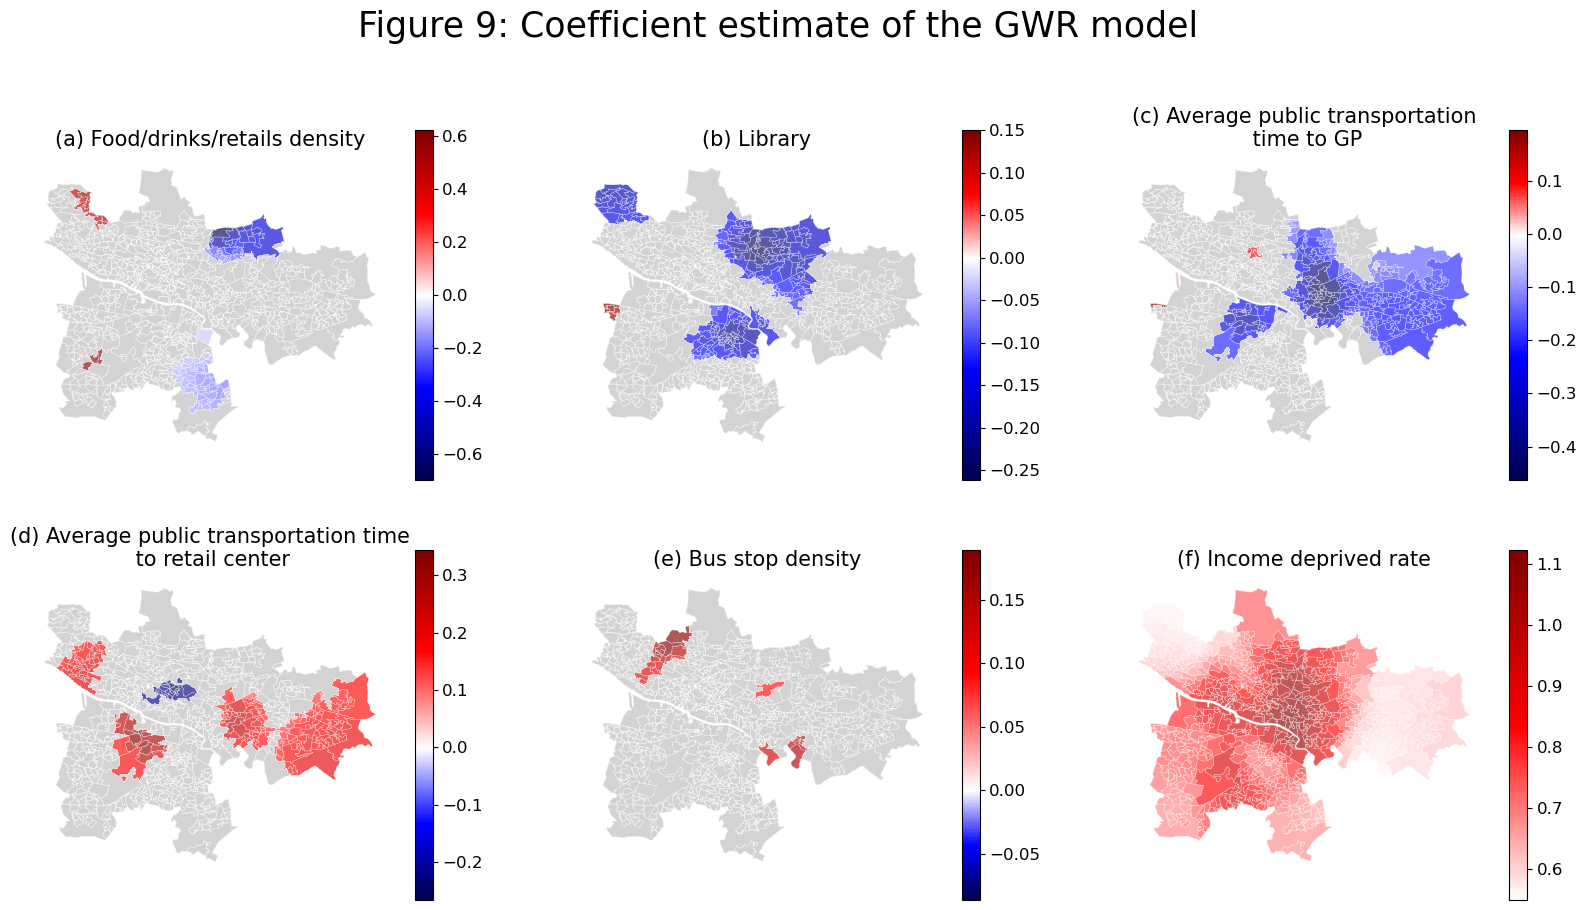

In [51]:
# plot comparison maps of parameters where the grey units pertain to statistically insignificant parameters

# add GWR parameters to GeoDataframe
df_dummies['gwr_intercept'] = gwr_results.params[:,0]
df_dummies['gwr_fdr']       = gwr_results.params[:,1]
df_dummies['gwr_li']        = gwr_results.params[:,2]
df_dummies['gwr_GP']        = gwr_results.params[:,3]
df_dummies['gwr_Ret']       = gwr_results.params[:,4]
df_dummies['gwr_bsd']       = gwr_results.params[:,5]
df_dummies['gwr_IncRate']   = gwr_results.params[:,6]

# filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

# plot coefficient estimates
title_dict = {
    'gwr_fdr':'(a) Food/drinks/retails density',
    'gwr_li':'(b) Library',
    'gwr_GP':'(c) Average public transportation\n time to GP',
    'gwr_Ret':'(d) Average public transportation time\n to retail center',
    'gwr_bsd':'(e) Bus stop density',
    'gwr_IncRate':'(f) Income deprived rate'}

# set up subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle('Figure 9: Coefficient estimate of the GWR model', fontsize=25,y=1)
axs = axs.flatten()

# loop through each variable to plot on each subplot
variables = ['gwr_fdr','gwr_li','gwr_GP','gwr_Ret','gwr_bsd','gwr_IncRate']  
for i, variable in enumerate(variables):
    ax = axs[i]
    ax.set_title(title_dict[variable],fontsize=15)
    
    # find min and max values of the variable
    variable_min = df_dummies[variable].min()
    variable_max = df_dummies[variable].max()
    vmin = np.min([variable_min])
    vmax = np.max([variable_max])

    # set up color map based on the min and max values of the variable
    cmap = plt.cm.seismic
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    # plot the variable
    df_dummies.plot(variable, cmap=sm.cmap, ax=ax, legend=False, vmin=vmin, vmax=vmax, **{'edgecolor':'white','linewidth':0.3, 'alpha':.65})
    if (gwr_filtered_t[:,i+1] == 0).any():
        df_dummies[gwr_filtered_t[:,i+1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'white','linewidth':0.3,})
    ax.set_axis_off()
    
    # set up colorbar for the subplot
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=12)

plt.show()


## 4. Discussion and limitations

Since the OLS model failed to capture the relationship between NMDP and neighborhood characteristics due to the spatial autocorrelation, GWR model was applied to consider the spatial non-stationarity.  The adjusted R2 improved and the spatial distribution of local R2 values generated by the GWR model (Fig. 8c) shows how the combined statistical effect of our predictor variables on NMDP varies across Glasgow. The most fitted results appear in the city center north of Clyde River. In contrast, in the northwest and southeastern edges of the city, the local R2 values are below the OLS model of 0.66, indicating that NMDP is not well explained by predictor variables. The reason might be other explanatory variables were not included in model which might account for variations in these regions.

The GWR model also generated significance map for each explanatory variable demonstrating how specific variable account for more in specific regions and highlighting significant regional variations ignored by the OLS (Fig. 9). These results imply that the association between neighborhood physical environment and NMDP is not static, and the direction and degree depend on each neighborhood. 

Firstly, research has shown that accessibility to mental health assistance decreases can lead to a higher prevalence of mental health issues, as evidenced by Packness et al. (2017). However, in this study, a majority of neighborhoods actually demonstrate a negative correlation between travel time and the proportion of the population suffering from mental health problems (NMDP), with longer travel times associated with lower NMDP. This suggests that people living in these neighborhoods may not be as sensitive to travel time, as they may own vehicles and have better access to resources that improve their physical and mental health, as noted by Koenig (2016). Interestingly, neighborhoods within a 500m buffer around libraries in the southeast side of the Clyde River and northwest northern edge of Glasgow show a negative association with NMDP as previous researches have suggested (Vaughan et al., 2016). However, a few neighborhoods on the west corner of the city have a positive association between library services and mental health issues (Fig. 9b).

In contrast, the income deprived rate as representation of neighborhood SES is positively significant in OLS model and in the local model for all neighborhoods in Glasgow (Fig. 9f). This is consistent with Yen et al.'s (2009) finding that neighborhood-level SES is a strong predictor variable of mental health condition. Additionally, density of bus stops is positively correlated to the NMDP in two neighborhoods clustering (Fig. 9e). According to Vaughan et al. (2016), having personal transportation is crucial to well-being, and residents living in neighborhoods with high convenience of public transportation might be more dependent on public transportation, indicating their vulnerability.

The relationship between density of drinks, food and retails of POIs and NMDP, and the relationship between average public travel time to leisure center and NMDP, are inconsistent. Spatially, negative coefficients of the density of POIs of drinks, food and retails are significant in the east of city, while positive coefficients are in the west (Fig. 9a). For the relationship between average public travel time to leisure center and NMDP, a portion of city center shows a significantly negative association while most of the neighborhoods shows positive association (Fig. 9d) and OLS model gives the positive result globally. The possible explanation might be neighborhood-level mechanisms counteracted the influences in those neighborhoods. However, further research will be necessary to identify the exact reasons behind the misalignment in the relationship in these regions.

While previous studies have shown a positive impact of green spaces and natural environments on mental health (Gianfredi et al., 2021), this study did not find a significant association. One potential limitation is that the distance calculation relied on Euclidean distance, which may not accurately reflect the actual travel distance and could oversimplify the distance from green spaces, potentially limiting interpretation of the findings.

The GWR model effectively captured the spatial heterogeneity in the data and indicated that the association between neighborhood characteristics and mental health may vary across the study region indicating that certain neighborhood characteristics may be more influential for mental health in some areas than in others. The reasons for these variations may be due to additional personal or environmental factors and require further analysis in future research.

However, neighborhood-level based data might lead to the potential heterogeneity within neighborhoods. The study was limited to counting the built environment characteristics that exist within census area (data zone), rather than the actual characteristics that surround individuals’ location. Therefore, ddjustment of objective measurements or measuring individual perception might be needed further.

Furthermore, although GWR accounted for the spatial patterns in the data, it generated bandwidth of 141 for all explanatory variables, which only accounted for 18.90% of the total data zones. The over-fitting and local multicollinearity of GWR model might lead to sign reversals opposite to the priori expectation (Comber et al., 2020). Therefore, other method like MGWR should be further applied to obtain more robust estimation results (An et al., 2022).


## 5. Conclusion

This study highlights the considerable geographic variation in associations between neighborhood level NMDP and neighborhood characteristics. According to OLS model, six predictor variables namely density of drinks, food and retails of POI, library availability, average public travel time to GP and leisure center, density of bus stop and neighborhood SES were significantly associated with the NMDP. Furthermore, neighborhood SES shows global association on NMDP. The range of positive to negative neighborhood characteristics observed across Glasgow suggests potential geographic clustering, which could help guiding mental health interventions to prevent the development of mental health problems. Additionally, the results of this study indicate that urban policy and construction may address the impact of the built environment on mental health across neighborhoods to manage mental health problems more effectively. Future research may further refine and test other predictor variables and construct an MGWR model to provide a more comprehensive understanding of the spatial variability in the relationship between neighborhood characteristics and mental health.

In [52]:
import io
import os
from nbformat import current

total_markdown = 0
total_heading = 0
total_code = 0

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".ipynb") and not file.endswith("checkpoint.ipynb") :
            print(os.path.join(root, file))
            with io.open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                nb = current.read(f, 'json')

            word_count_markdown = 0
            word_count_heading = 0
            word_count_code = 0
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == "markdown":
                    word_count_markdown += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "heading":
                    word_count_heading += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "code":
                    word_count_code += len(cell['input'].replace('#', '').lstrip().split(' '))
            total_markdown += word_count_markdown
            total_heading += word_count_heading
            total_code += word_count_code
            print("{} Words in notebooks' markdown" .format(word_count_markdown))
            print("{} Words in notebooks' heading" .format(word_count_heading))
            print("{} Words in notebooks' code" .format(word_count_code))
            print("")

./Draft project.ipynb
2992 Words in notebooks' markdown
67 Words in notebooks' heading
5127 Words in notebooks' code



## Reference list

Anselin, L. 1988. Spatial econometrics: methods and models (Vol. 4). _Springer Science & Business Media_.  

An, R., Wu, Z., Tong, Z., Qin, S., Zhu, Y., & Liu, Y. 2022. How the built environment promotes public transportation in Wuhan: A multiscale geographically weighted regression analysis. _Travel Behaviour and Society_, __29__, 186–199.  

Brunsdon, C., Fotheringham, A. S., & Charlton, M. E. 1996. Geographically weighted regression: a method for exploring spatial nonstationarity. _Geographical analysis_, __28__(4), 281-298.  

Chau, H. W., Gilzean, I., Jamei, E., Palmer, L., Preece, T., & Quirke, M. 2022. Comparative Analysis of 20-Minute Neighbourhood Policies and Practices in Melbourne and Scotland. _Urban Planning_, __7__(4), 13–24.  

Comber, A., Chi, K., Huy, M. Q., Nguyen, Q., Lu, B., Phe, H. H., & Harris, P. 2020. Distance metric choice can both reduce and induce collinearity in geographically weighted regression. _Environment and Planning B: Urban Analytics and City Science_, __47__(3), 489–507.  

Gianfredi, V., Buffoli, M., Rebecchi, A., Croci, R., Oradini-Alacreu, A., Stirparo, G., Marino, A., Odone, A., Capolongo, S., & Signorelli, C. 2021. Association between Urban Greenspace and Health: A Systematic Review of Literature. _International Journal of Environmental Research and Public Health_, __18__(10).  

Ha, H. 2018. Using geographically weighted regression for social inequality analysis: association between mentally unhealthy days (MUDs) and socioeconomic status (SES) in U.S. counties.   

Hartig, T., & Kahn, P. H. 2016. Living in cities, naturally. Science, __352__(6288), 938–940.  

Houlden, V., Porto de Albuquerque, J., Weich, S., & Jarvis, S. 2019. A spatial analysis of proximate greenspace and mental wellbeing in London. _Applied Geography_, __109__, 102036. 

Houlden, V., Weich, S., de Albuquerque, J. P., Jarvis, S., & Rees, K. 2018. The relationship between greenspace and the mental wellbeing of adults: A systematic review. _PloS One_, __13__(9). 

Kim, D. 2008. Blues from the Neighborhood? Neighborhood Characteristics and Depression. _Epidemiologic Reviews_, __30__(1), 101–117.   

Koenig, H. G. 2016. Religion and Medicine II: Religion, Mental Health, and Related Behaviors. __31__(1), 97–109.  

la Rosa, D. 2014. Accessibility to greenspaces: GIS based indicators for sustainable planning in a dense urban context. _Ecological Indicators_, __42__, 122–134.  

Levasseur, M., Généreux, M., Bruneau, J. F., Vanasse, A., Chabot, É., Beaulac, C., & Bédard, M. M. 2015. Importance of proximity to resources, social support, transportation and neighborhood security for mobility and social participation in older adults: results from a scoping study. _BMC Public Health_, __15__(1).  

NHS Greater Glasgow and Clyde. (2019). _Joint Strategic Needs Assessment: Mental Health and Wellbeing_. [Online].[Accessed 15 March 2023]. Available from https://www.nhsggc.org.uk/  

Packness, A., Waldorff, F. B., Christensen, R. de P., Hastrup, L. H., Simonsen, E., Vestergaard, M., & Halling, A. 2017. Impact of socioeconomic position and distance on mental health care utilization: a nationwide Danish follow-up study. _Social Psychiatry and Psychiatric Epidemiology_, __52__(11), 1405–1413.  

Ross, C. E. 2000. Neighborhood disadvantage and adult depression. _Journal of Health and Social Behavior_, __41__(2), 177–187.  

Scottish Government. 2017. _Mental Health Strategy 2017-2027._[Online]. [Accessed 15 March 2023]. Available from: https://www.gov.scot/  

Scottish Government. 2018. _Mental Health in Scotland: A 10-Year Vision_. [Online]. [Accessed 15 March 2023]. Available from: https://www.gov.scot/  

Scottish Government. 2022. _Scottish Index of Multiple Deprivation 2020_. [Online]. [Accessed 15 March 2023]. Available from: https://www.gov.scot/

The Glasgow Indicator Project. 2016. _Glasgow Indicators: Mental Health._ [Online].[Accessed 15 March 2023]. Available from: https://www.understandingglasgow/

Vaughan, M., LaValley, M. P., Alheresh, R., & Keysor, J. J. (2016). Which Features of the Environment Impact Community Participation of Older Adults? A Systematic Review and Meta-Analysis. _Journal of Aging and Health_, __28__(6), 957–978.  

Wang, R., Feng, Z., & Pearce, J. 2022. Neighbourhood greenspace quantity, quality and socioeconomic inequalities in mental health. _Cities_, __129__, 103815.  

Yen, I. H., Michael, Y. L., & Perdue, L. 2009. Neighborhood environment in studies of health of older adults: a systematic review. _American Journal of Preventive Medicine_, __37__(5), 455–463. 
